In [47]:
from IPython.display import clear_output

In [218]:
import time
import importlib
import numpy as np
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from scipy.linalg import norm, pinv, toeplitz
from scipy.signal import find_peaks
from scipy import fft
from tqdm import tqdm, trange

In [219]:
from numpy import pi, fft
import torch
from torch.nn.functional import relu, mse_loss, conv1d
from torch.nn import Module, Parameter, ReLU

device = torch.device('cpu')
print(device)

cpu


In [50]:
class ComplexLISTA(Module):
    
    def __init__(self, M, N, maxit):
        super(ComplexLISTA, self).__init__()
    
        # Real and imaginary Wg and We matricies 
        self.Wre = torch.nn.Parameter(torch.zeros([maxit+1, N, M]), requires_grad=True)
        self.Wrg = torch.nn.Parameter(torch.zeros([maxit+1, N, N]), requires_grad=True)
        self.Wie = torch.nn.Parameter(torch.zeros([maxit+1, N, M]), requires_grad=True)
        self.Wig = torch.nn.Parameter(torch.zeros([maxit+1, N, N]), requires_grad=True)
        
        # alpha and lambda hyper-parameters to LASSO/ISTA
        self.theta = torch.nn.Parameter(torch.ones(maxit+1), requires_grad=True)
        
        # Save the passed values
        self.M = M
        self.N = N
        self.maxit = maxit
        self.relu = ReLU()

        return
    
    def forward(self, yr, yi, epsilon=1e-10):
        
        Wret = torch.transpose(self.Wre[0], 0, 1)
        Wiet = torch.transpose(self.Wie[0], 0, 1)
        Wrgt = torch.transpose(self.Wrg[0], 0, 1)
        Wigt = torch.transpose(self.Wig[0], 0, 1)
                
        # Apply We branch to y to 0-th iteration
        zr = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
        zi = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
        
        # Apply soft-thresholding according to Eldar's paper.
        xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
        xr = torch.divide(zr, xabs + epsilon) * self.relu(xabs - self.theta[0])
        xi = torch.divide(zi, xabs + epsilon) * self.relu(xabs - self.theta[0])
        
        for t in range(1, self.maxit+1):
            
            Wret = torch.transpose(self.Wre[0], 0, 1)
            Wiet = torch.transpose(self.Wie[0], 0, 1)
            Wrgt = torch.transpose(self.Wrg[0], 0, 1)
            Wigt = torch.transpose(self.Wig[0], 0, 1)
        
            # Apply We branch to y to t-th iteration
            ar = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
            ai = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
            
            # Apply Wg branch to x^(t) for t-th iteration
            br = torch.matmul(xr, Wrgt) - torch.matmul(xi, Wigt)
            bi = torch.matmul(xi, Wrgt) + torch.matmul(xr, Wigt)
            
            # Add the two branches                                                                           
            zr = ar + br
            zi = ai + bi
            
            # Apply soft-thresholding
            xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
            xr = torch.divide(zr, xabs + epsilon) * self.relu(xabs - self.theta[t])
            xi = torch.divide(zi, xabs + epsilon) * self.relu(xabs - self.theta[t])
      
        return xr, xi

In [51]:
class ComplexLISTA_Toeplitz(Module):
    
    def __init__(self, M, N, maxit):
        super(ComplexLISTA_Toeplitz, self).__init__()
    
        # Real and imaginary Wg and We matricies 
        self.Wre = Parameter(torch.zeros([maxit+1, N, M]), requires_grad=True)
        self.Wie = Parameter(torch.zeros([maxit+1, N, M]), requires_grad=True)
        self.hrg = Parameter(torch.zeros([maxit+1, 1, 1, N]), requires_grad=True) # dimension such that it works with conv1d
        self.hig = Parameter(torch.zeros([maxit+1, 1, 1, N]), requires_grad=True)
        
        # alpha and lambda hyper-parameters to LASSO/ISTA
        self.theta = Parameter(torch.ones(maxit+1), requires_grad=True)
        
        # Save the passed values
        self.M = M
        self.N = N
        self.maxit = maxit
        self.relu = ReLU()

        return
    
    def forward(self, yr, yi, epsilon=1e-10):
        
        Wret = torch.transpose(self.Wre[0], 0, 1)
        Wiet = torch.transpose(self.Wie[0], 0, 1)
                
        # Apply We branch to y to 0-th iteration
        zr = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
        zi = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
        
        # Apply soft-thresholding according to Eldar's paper.
        xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
        xr = torch.divide(zr, xabs + epsilon) * self.relu(xabs - self.theta[0])
        xi = torch.divide(zi, xabs + epsilon) * self.relu(xabs - self.theta[0])
        
        for t in range(1, self.maxit+1):

            Wret = torch.transpose(self.Wre[t], 0, 1)
            Wiet = torch.transpose(self.Wie[t], 0, 1)
            hrgt = self.hrg[t]
            higt = self.hig[t]
        
            # Apply We branch to y to t-th iteration
            ar = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
            ai = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
            
            # Apply hg conv1d branch to x^(t) for t-th iteration
            br = conv1d(xr.unsqueeze(1), hrgt, padding='same') - conv1d(xi.unsqueeze(1), higt, padding='same')
            bi = conv1d(xi.unsqueeze(1), hrgt, padding='same') + conv1d(xr.unsqueeze(1), higt, padding='same')
            
            # Add the two branches                                                                           
            zr = ar + br.squeeze(1)
            zi = ai + bi.squeeze(1)
            
            # Apply soft-thresholding
            xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
            xr = torch.divide(zr, xabs + epsilon) * self.relu(xabs - self.theta[t])
            xi = torch.divide(zi, xabs + epsilon) * self.relu(xabs - self.theta[t])
      
        return xr, xi

In [52]:
class ComplexLISTA_Weights(Module):
    
    def __init__(self, M, N, maxit):
        super(ComplexLISTA_Weights, self).__init__()
    
        # Real and imaginary Wg and We matricies 
        self.Wre = Parameter(torch.zeros([maxit+1, N, M]), requires_grad=True)
        self.Wie = Parameter(torch.zeros([maxit+1, N, M]), requires_grad=True)
        self.Wg = Parameter(torch.zeros([maxit+1, M]), requires_grad=True) # dimension such that it works with conv1d
        
        # alpha and lambda hyper-parameters to LASSO/ISTA
        self.theta = Parameter(torch.ones(maxit+1), requires_grad=True)
        
        # Save the passed values
        self.M = M
        self.N = N
        self.maxit = maxit

        # Create useful relu layer
        self.relu = ReLU()

        # Assuming the measurement model
        self.complex_exp = lambda x : np.exp(2j*pi*x)
        self.fgrid = fft.fftfreq(N)
        self.ula = np.arange(M)
        self.arg = np.outer(self.ula, 2*pi*self.fgrid)

        # Predefine useful matricies
        self.C = torch.from_numpy(np.cos(self.arg)).to(torch.float32).unsqueeze(0).unsqueeze(0)
        self.S = torch.from_numpy(np.sin(self.arg)).to(torch.float32).unsqueeze(0).unsqueeze(0)
        self.C = Parameter(self.C, requires_grad=False)
        self.S = Parameter(self.S, requires_grad=False)

        return
    
    def forward(self, yr, yi, epsilon=1e-10):
        
        Wret = torch.transpose(self.Wre[0], 0, 1)
        Wiet = torch.transpose(self.Wie[0], 0, 1)
                
        # Apply We branch to y to 0-th iteration
        zr = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
        zi = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
        
        # Apply soft-thresholding according to Eldar's paper.
        xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
        xr = torch.divide(zr, xabs + epsilon) * self.relu(xabs - self.theta[0])
        xi = torch.divide(zi, xabs + epsilon) * self.relu(xabs - self.theta[0])
        
        for t in range(1, self.maxit+1):

            Wret = torch.transpose(self.Wre[t], 0, 1)
            Wiet = torch.transpose(self.Wie[t], 0, 1)
        
            # Apply We branch to y to t-th iteration
            ar = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
            ai = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
            
            # Apply hg conv1d branch to x^(t) for t-th iteration
            hrgt = torch.matmul(self.Wg[t], self.C)
            higt = torch.matmul(self.Wg[t], self.S)

            br = conv1d(xr.unsqueeze(1), hrgt, padding='same') - conv1d(xi.unsqueeze(1), higt, padding='same')
            bi = conv1d(xi.unsqueeze(1), hrgt, padding='same') + conv1d(xr.unsqueeze(1), higt, padding='same')

            # Add the two branches                                                                           
            zr = ar + br.squeeze(1)
            zi = ai + bi.squeeze(1)
            
            # Apply soft-thresholding
            xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
            xr = torch.divide(zr, xabs + epsilon) * self.relu(xabs - self.theta[t])
            xi = torch.divide(zi, xabs + epsilon) * self.relu(xabs - self.theta[t])
      
        return xr, xi

In [53]:
class ComplexLISTA_Weights_Nested(Module):
    
    def __init__(self, M1, M2, N, maxit):
        super(ComplexLISTA_Weights_Nested, self).__init__()
    
        # Real and imaginary Wg and We matricies 
        self.M = M1 + M2
        self.Wre = Parameter(torch.zeros([maxit+1, N, self.M]), requires_grad=True)
        self.Wie = Parameter(torch.zeros([maxit+1, N, self.M]), requires_grad=True)
        self.win = Parameter(torch.zeros([maxit+1, M1]), requires_grad=True) # dimension such that it works with conv1d
        self.wout = Parameter(torch.zeros([maxit+1, M2]), requires_grad=True) # dimension such that it works with conv1d

        
        # alpha and lambda hyper-parameters to LASSO/ISTA
        self.theta = Parameter(torch.ones(maxit+1), requires_grad=True)
        
        # Save the passed values
        self.M1 = M1
        self.M2 = M2
        self.N = N
        self.maxit = maxit

        # Create useful relu layer
        self.relu = ReLU()

        # Assuming the measurement model
        self.complex_exp = lambda x : np.exp(2j*pi*x)
        self.fgrid = fft.fftfreq(N)
        
        self.inner = np.arange(M1)
        self.outer = np.arange(1, M2+1)*(M1)

        self.argin = np.outer(self.inner, 2*pi*self.fgrid)
        self.argout = np.outer(self.outer, 2*pi*self.fgrid)

        # Predefine useful matricies
        self.Cin = torch.from_numpy(np.cos(self.argin)).to(torch.float32).unsqueeze(0).unsqueeze(0)
        self.Sin = torch.from_numpy(np.sin(self.argin)).to(torch.float32).unsqueeze(0).unsqueeze(0)
        self.Cin = Parameter(self.Cin, requires_grad=False)
        self.Sin = Parameter(self.Sin, requires_grad=False)
        
        self.Cout = torch.from_numpy(np.cos(self.argout)).to(torch.float32).unsqueeze(0).unsqueeze(0)
        self.Sout = torch.from_numpy(np.sin(self.argout)).to(torch.float32).unsqueeze(0).unsqueeze(0)
        self.Cout = Parameter(self.Cout, requires_grad=False)
        self.Sout = Parameter(self.Sout, requires_grad=False)

        return
    
    def forward(self, yr, yi, epsilon=1e-10):
        
        Wret = torch.transpose(self.Wre[0], 0, 1)
        Wiet = torch.transpose(self.Wie[0], 0, 1)
                
        # Apply We branch to y to 0-th iteration
        zr = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
        zi = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
        
        # Apply soft-thresholding according to Eldar's paper.
        xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
        xr = torch.divide(zr, xabs + epsilon) * self.relu(xabs - self.theta[0])
        xi = torch.divide(zi, xabs + epsilon) * self.relu(xabs - self.theta[0])
        
        for t in range(1, self.maxit+1):

            Wret = torch.transpose(self.Wre[t], 0, 1)
            Wiet = torch.transpose(self.Wie[t], 0, 1)
        
            # Apply We branch to y to t-th iteration
            ar = torch.matmul(yr, Wret) - torch.matmul(yi, Wiet)
            ai = torch.matmul(yi, Wret) + torch.matmul(yr, Wiet)
            
            # Apply hg conv1d branch to x^(t) for t-th iteration
            hrgt = torch.matmul(self.win[t], self.Cin) + torch.matmul(self.wout[t], self.Cout)
            higt = torch.matmul(self.win[t], self.Sin) + torch.matmul(self.wout[t], self.Sout)

            br = conv1d(xr.unsqueeze(1), hrgt, padding='same') - conv1d(xi.unsqueeze(1), higt, padding='same')
            bi = conv1d(xi.unsqueeze(1), hrgt, padding='same') + conv1d(xr.unsqueeze(1), higt, padding='same')

            # Add the two branches                                                                           
            zr = ar + br.squeeze(1)
            zi = ai + bi.squeeze(1)
            
            # Apply soft-thresholding
            xabs = torch.sqrt(torch.square(zr) + torch.square(zi) + epsilon)
            xr = torch.divide(zr, xabs + epsilon) * self.relu(xabs - self.theta[t])
            xi = torch.divide(zi, xabs + epsilon) * self.relu(xabs - self.theta[t])
      
        return xr, xi

In [54]:
class sparse_dataset(Dataset):
    def __init__(self, N, K, Nexamples, sig=0.0, A=None):
        self.X = np.zeros((Nexamples, N, 1))
        for ii in trange(Nexamples):
            self.X[ii,...] = self.generate_sparse_vector(N, K)
        #self.X *= np.random.randn(*self.X.shape)
        self.X = torch.from_numpy(self.X).reshape(Nexamples, N)
        self.Y = self.X @ A.T
        self.Y = self.Y + sig * torch.randn_like(self.Y)
    
    def __getitem__(self, i):
        return (self.X[i, ...], self.Y[i, ...])
    
    def __len__(self, ):
        return self.X.shape[0]
    
    def generate_sparse_vector(self, N, K):
        x = np.zeros((N,1))
        x[:K,...] = 1.
        np.random.shuffle(x)
        return x
    
    def regenerate_measurements(self, sig=0.0, A=None):
        self.Y = self.X @ A.T 
        self.Y = self.Y + sig * torch.randn_like(self.Y)
        return self

In [55]:
# Create training data
maxit = 10
M = 64
N = 512
sig = 0.4
epochs = 10
batchSize = 100
testFreq = 1
trainingPoints = 10_000
testingPoints = 100
sparsityLevel = 5

# Create ULA and Nested Array Matricies
M1 = M // 2
M2 = M - M1

inner = np.arange(M1)
outer = np.arange(1, M2+1)*(M1)

uniform = np.arange(M).reshape(-1,1)
nested = np.concatenate([inner, outer]).reshape(-1, 1)

fgrid = fft.fftfreq(N).reshape(-1, 1)

complex_exp = lambda x : np.exp(1j* 2*np.pi * x )
A_u = complex_exp(uniform @ fgrid.T)
A_n = complex_exp(nested @ fgrid.T)

In [56]:
''' Or load'''
dataset_training = torch.load("training_data.pt")
dataset_testing = torch.load("testing_data.pt")
dataloader_training = DataLoader(dataset_training, 
                                 batch_size = batchSize, shuffle=True)
dataloader_testing = DataLoader(dataset_testing, 
                                 batch_size = testingPoints, shuffle=False)

In [26]:
dataset_training = sparse_dataset(N, sparsityLevel, trainingPoints, sig=sig, A=A_u) # nested
dataloader_training = DataLoader(dataset_training, 
                                 batch_size = batchSize, shuffle=True)
dataset_testing = sparse_dataset(N, sparsityLevel, testingPoints, sig=sig, A=A_u) # nested
dataloader_testing = DataLoader(dataset_testing, 
                                 batch_size = testingPoints, shuffle=False)
torch.save(dataset_training, "training_data.pt")
torch.save(dataset_testing, "testing_data.pt")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2126.71it/s]


In [57]:
batches = int(trainingPoints/batchSize)
#print(trainingPoints/batchSize)
training_losslist = np.zeros(epochs * batches)
testing_losslist = np.zeros(epochs * batches)

#model = ComplexLISTA_Weights(M, N, maxit)
model = ComplexLISTA_Toeplitz(M, N, maxit)

model.to(device)
# for name, weights in model.named_parameters():
#     print(name, weights)
#print(model.state_dict())

ComplexLISTA_Toeplitz(
  (relu): ReLU()
)

In [58]:
# Initialize Wg matrix according to Eldar
X, Y = dataset_training[:100]
print(X.shape, Y.shape)
X = X.numpy().T
Y = Y.numpy().T
XHX = X.T.conj() @ X 
XHXinv = pinv(XHX)
Phi = Y @ XHXinv @ X.T.conj() # conjugates omitted since X will be real
PhiH = torch.from_numpy(Phi.conj().T)
L = np.max(np.abs(np.linalg.eigvals(Phi.conj().T @ Phi)))

#print(model.state_dict()['Wre'])
with torch.no_grad():
    for name, param in model.named_parameters():
        if 'Wre' in name:
            param.copy_(1/L * PhiH.real)
        if 'Wie' in name:
            param.copy_(1/L * PhiH.imag)
#         if 'win' in name: # for weighted lista
#             param.copy_(1/L * torch.ones(model.maxit+1, M1))
#         if 'wout' in name: # for weighted lista
#             param.copy_(1/L * torch.ones(model.maxit+1, M2))
        if 'theta' in name:
            param.copy_(0.01/L * torch.ones(model.maxit+1))

torch.Size([100, 512]) torch.Size([100, 64])


In [59]:
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
obj = torch.nn.MSELoss()
t = trange(epochs)
#t = range(epochs)
for e in t:
    for i, data in enumerate(dataloader_training):

        idx = e * batches + i
        x, y = data
        
        # Split data to real and complex
        xr = x.to(torch.float32).to(device)
        xi = torch.zeros_like(xr).to(torch.float32).to(device)
        
        yr = y.real.to(torch.float32).to(device)
        yi = y.imag.to(torch.float32).to(device)
        
        # Send through model
        xpredr, xpredi = model(yr, yi)
        
        loss = obj(xpredr, xr) + obj(xpredi, xi)

        with torch.no_grad():
            training_losslist[idx] = loss

        loss.backward()    
        optim.step()
        optim.zero_grad()
        
        if testFreq and idx % testFreq == 0:
            for k, test_data in enumerate(dataloader_testing):
                
                x, y = test_data
                
                xr = x.to(torch.float32).to(device)
                xi = torch.zeros_like(xr).to(torch.float32).to(device)
                
                yr = y.real.to(torch.float32).to(device)
                yi = y.imag.to(torch.float32).to(device)
                
                xpredr, xpredi = model(yr, yi)
                xpredr = xpredr.detach().cpu()
                xpredi = xpredi.detach().cpu()

                testing_losslist[idx] += torch.mean((xpredr.cpu() - xr.cpu())**2) + torch.mean((xpredi.cpu() - xi.cpu())**2)

        t.set_description("Batch: {}/{}\t Training Loss: {}\t Validation Loss: {}".format(i, len(dataloader_training), training_losslist[idx], testing_losslist[idx]), refresh=True)

        #clear_output(wait=True)
        #print("Epoch: {}\t Batch: {}\t Training Loss: {}\t Validation Loss: {}".format(e, i, training_losslist[idx], testing_losslist[idx]))

        #print("Epoch: {}\t Batch: {}\t Training Loss: {}\t".format(e, i, training_losslist[idx]), end='\r')

Batch: 7/100	 Training Loss: 0.009316558949649334	 Validation Loss: 0.009282160550355911:   0%|                                                                                                                                                         | 0/10 [00:11<?, ?it/s]


KeyboardInterrupt: 

0.009450112469494343


/home/jake/mambaforge/envs/torch-v1.9.0/lib/python3.8/site-packages/matplotlib_inline/backend_inline.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


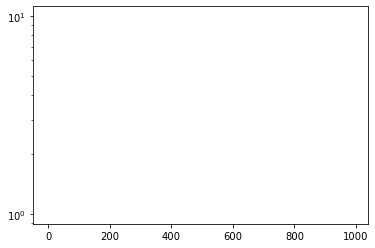

In [60]:
print(training_losslist[0])
plt.semilogy(training_losslist[10:])
plt.semilogy(testing_losslist[10:])
torch.save(model.state_dict(), "weights.pt")
np.save("train_loss.npy", training_losslist)
np.save("test_loss.npy", testing_losslist)

In [114]:
''' or load the weights '''
model.load_state_dict(torch.load("weights.pt", map_location=device))

<All keys matched successfully>

In [62]:
x_test, y_test = dataset_testing[2]

yr = y_test.real.to(torch.float32).to(device)
yi = y_test.imag.to(torch.float32).to(device)

yr = yr.unsqueeze(0)
yi = yi.unsqueeze(0)

xpredr, xpredi = model(yr, yi)
# xistar, xistai = model_ista(yr, yi)

x_test = x_test.numpy()
x_pred = np.zeros_like(x_test, dtype=complex)
x_pred.real = xpredr.detach().cpu().numpy()
x_pred.imag = xpredi.detach().cpu().numpy()

# x_ista = np.zeros_like(x_test, dtype=complex)
# x_ista.real = xistar.detach().numpy()
# x_ista.imag = xistai.detach().numpy()

S_test = np.abs(x_test)
S_pred = np.abs(x_pred)
# S_ista = np.abs(x_ista)

S_test /= S_test.max()
S_pred /= S_pred.max()
# S_ista /= S_ista.max()

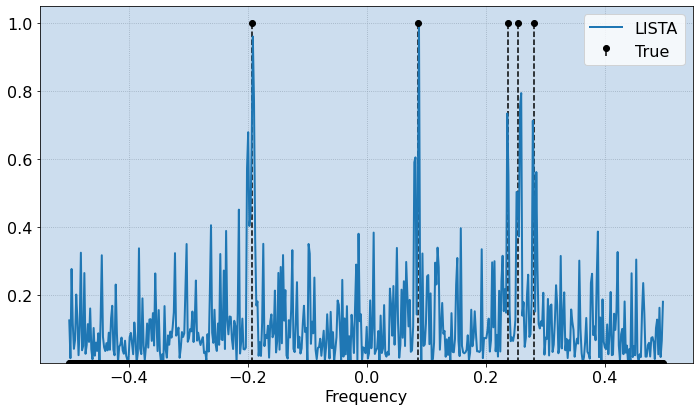

In [63]:
# Plot ULA
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(fft.fftshift(fft.fftfreq(N)), fft.fftshift(S_pred), linewidth=2, label='LISTA')
#ax.plot(fft.fftshift(fft.fftfreq(N)), fft.fftshift(S_ista), linewidth=2, label='ISTA')
ax.stem(fft.fftshift(fft.fftfreq(N)), fft.fftshift(S_test), 'k', markerfmt='ko', linefmt='k--', label='True',  basefmt=" ")
y1, y2 = ax.get_ylim()
#ax.vlines(fft.fftshift(fft.fftfreq(N)[np.nonzero(S_test)]), linestyle='--', ymin=0, ymax=y2, color='k', label='True')
ax.set_ylim(0.001, y2)
ax.set_xlabel('Frequency')
ax.set_title('')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#CCDDEE')

ax.legend()
plt.tight_layout()
plt.show()

In [347]:
NMonteCarlo = 100

# Use our testing data to create different SNR,
#SNRs = np.arange(-25, 25, 1)
#sigs = np.sqrt(sparsityLevel * np.power(10, -SNRs/10))
sigs = np.sqrt(np.logspace(-2.5, 2.0, 15))
mc_losses_t = np.zeros(len(sigs))
hit_rates_t = np.zeros(len(sigs))

model.load_state_dict(torch.load("weights_toeplitz.pt", map_location=device))
model.eval()

idx = 0 
for i, sig in tqdm(enumerate(sigs)):
    dataMC = dataset_testing.regenerate_measurements(sig, A_u)
    dataloaderMC = DataLoader(dataMC, batch_size = testingPoints, shuffle=False)
    for j, data in enumerate(dataloaderMC):


        x_test, y_test = data
        
        xr = x_test.to(torch.float32).to(device)
        xi = torch.zeros_like(xr).to(torch.float32).to(device)
        yr = y_test.real.to(torch.float32).to(device)
        yi = y_test.imag.to(torch.float32).to(device)

        xpredr, xpredi = model(yr, yi)
        
        x_test = x_test.numpy()
        x_pred = np.zeros_like(x_test, dtype=complex)
        x_pred.real = xpredr.detach().cpu().numpy()
        x_pred.imag = xpredi.detach().cpu().numpy()

        S_test = np.abs(x_test)
        S_pred = np.abs(x_pred)
        S_test /= S_test.max()
        S_pred /= S_pred.max()
        
        if i == 0:
            S_save = S_pred
            x_save = x_test
            
        # NMSE loss
        num = mse_loss(xpredr.cpu(), xr.cpu()) +  mse_loss(xpredi.cpu(), xi.cpu())
        den = mse_loss(xr.cpu(), torch.zeros_like(xr.cpu())) +  mse_loss(xi.cpu(), torch.zeros_like(xi.cpu()))
        mc_losses_t[idx] +=  num/den 
        
        # hit-rate
        ssr = 0
        for signal, truth in zip(S_pred, x_test):
            find_peaks(signal, height=0)
            peak_ind, peak_info = find_peaks(signal, height=0)    
            peak_height = peak_info['peak_heights']
            peak_sortind = peak_ind[peak_height.argsort()]
            pred_peaks = peak_sortind[-sparsityLevel:]
            true_peaks = np.nonzero((truth))[0]
            ssr += np.mean(np.in1d(true_peaks, pred_peaks))
        hit_rates_t[idx] = ssr / S_pred.shape[0]
                           
    #mc_losses[idx] /= len(dataloaderMC)
    idx += 1


15it [00:04,  3.12it/s]


In [349]:
NMonteCarlo = 100

# Use our testing data to create different SNR,
#SNRs = np.arange(-25, 25, 1)
#sigs = np.sqrt(sparsityLevel * np.power(10, -SNRs/10))
sigs = np.sqrt(np.logspace(-2.5, 2.0, 15))
mc_losses_w = np.zeros(len(sigs))
hit_rates_w = np.zeros(len(sigs))

model = ComplexLISTA_Weights(M, N, maxit)
model.load_state_dict(torch.load("weights.pt", map_location=device))
model.eval()

idx = 0 
for i, sig in tqdm(enumerate(sigs)):
    dataMC = dataset_testing.regenerate_measurements(sig, A_u)
    dataloaderMC = DataLoader(dataMC, batch_size = testingPoints, shuffle=False)
    for j, data in enumerate(dataloaderMC):


        x_test, y_test = data
        
        xr = x_test.to(torch.float32).to(device)
        xi = torch.zeros_like(xr).to(torch.float32).to(device)
        yr = y_test.real.to(torch.float32).to(device)
        yi = y_test.imag.to(torch.float32).to(device)

        xpredr, xpredi = model(yr, yi)
        
        x_test = x_test.numpy()
        x_pred = np.zeros_like(x_test, dtype=complex)
        x_pred.real = xpredr.detach().cpu().numpy()
        x_pred.imag = xpredi.detach().cpu().numpy()

        S_test = np.abs(x_test)
        S_pred = np.abs(x_pred)
        S_test /= S_test.max()
        S_pred /= S_pred.max()
        
        if i == 0:
            S_save = S_pred
            x_save = x_test
            
        # NMSE loss
        num = mse_loss(xpredr.cpu(), xr.cpu()) +  mse_loss(xpredi.cpu(), xi.cpu())
        den = mse_loss(xr.cpu(), torch.zeros_like(xr.cpu())) +  mse_loss(xi.cpu(), torch.zeros_like(xi.cpu()))
        mc_losses_w[idx] +=  num/den 
        
        # hit-rate
        ssr = 0
        for signal, truth in zip(S_pred, x_test):
            find_peaks(signal, height=0)
            peak_ind, peak_info = find_peaks(signal, height=0)    
            peak_height = peak_info['peak_heights']
            peak_sortind = peak_ind[peak_height.argsort()]
            pred_peaks = peak_sortind[-sparsityLevel:]
            true_peaks = np.nonzero((truth))[0]
            ssr += np.mean(np.in1d(true_peaks, pred_peaks))
        hit_rates_w[idx] = ssr / S_pred.shape[0]
                           
    #mc_losses[idx] /= len(dataloaderMC)
    idx += 1


15it [00:05,  3.00it/s]


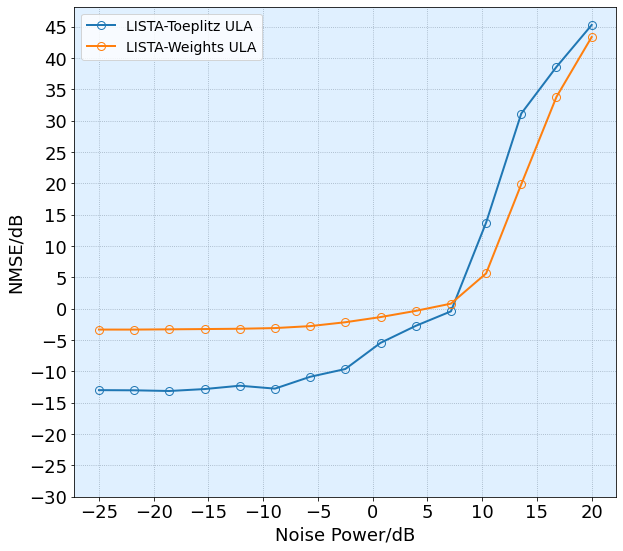

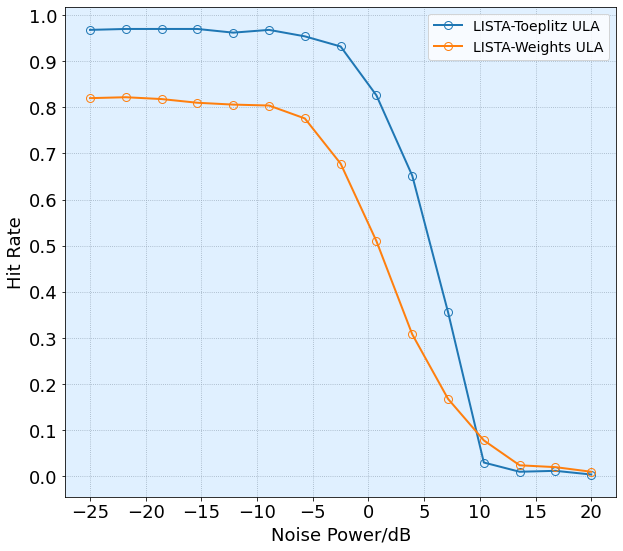

In [358]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(9, 8))
noise_power_db = 20*np.log10(sigs)
nmse_t = 10*np.log10(mc_losses_t)
nmse_w = 10*np.log10(mc_losses_w)


ax.plot(noise_power_db, nmse_t, marker='o', linewidth=2, markersize=8, markerfacecolor="None", label="LISTA-Toeplitz ULA")
ax.plot(noise_power_db, nmse_w, marker='o', linewidth=2, markersize=8, markerfacecolor="None", label="LISTA-Weights ULA")


ax.set_xlabel('Noise Power/dB', fontsize=18)
ax.set_ylabel('NMSE/dB', fontsize=18)
ax.set_title('')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#E0F0FF')
ax.set_yticks(np.arange(-30, np.ceil(max(nmse))+1, 5))
ax.set_xticks(np.arange(-25, 20+1, 5))
ax.legend(fontsize=14)
#plt.title("NMSE vs Noise Power", fontsize=22)
plt.tight_layout()
fig.patch.set_alpha(1)
plt.savefig("noise_pwr.png", transparent=False)


fig, ax = plt.subplots(figsize=(9, 8))

ax.plot(noise_power_db, hit_rates_t, marker='o', linewidth=2, markersize=8, markerfacecolor="None", label="LISTA-Toeplitz ULA")
ax.plot(noise_power_db, hit_rates_w, marker='o', linewidth=2, markersize=8, markerfacecolor="None", label="LISTA-Weights ULA")

ax.set_xlabel('Noise Power/dB', fontsize=18)
ax.set_ylabel('Hit Rate', fontsize=18)
ax.set_title('')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#E0F0FF')

ax.set_yticks(np.arange(0, 1+0.1, 0.1))
ax.set_xticks(np.arange(-25, 20+1, 5))

ax.legend(fontsize=14)
#plt.title("Hit Rate vs Noise Power", fontsize=22)
plt.tight_layout()
fig.patch.set_alpha(1)
plt.savefig("hit_rate.png", transparent=False)
